In [1]:
import os
import time
import keras.utils

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input,Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, BatchNormalization
from keras.layers import LeakyReLU, Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
from IPython import display
from PIL import Image


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
tf.compat.v1.keras.backend.set_session(sess)

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1



### Three helper functions
1. generateTheta(L, dim) - generate L random samples from unit 'dim' space
2. generateQZ(batchsize, latent_dim) - generate samples from ideal q_z distribution
3. stitchImages(I, axis) - helps with visualization

In [2]:
def generateTheta(L, dim):
    res = [w / np.sqrt((w ** 2).sum()) for w in np.random.normal(size=(L, dim))]
    return np.asarray(res)

def generateQZ(batchsize, latent_dim):
    return np.random.normal(size=(batchsize, latent_dim))

def stitchImages(I, axis=0):
    n, N, M, K = I.shape
    if axis == 0:
        img = np.zeros((N * n, M, K))
        for i in range(n):
            img[i * N: (i + 1) * N, :, :] = I[i, :, :, :]
    else:
        img = np.zeros((N, M * n, K))
        for i in range(n):
            img[:, i * M: (i + 1) * M, :] = I[i, :, :, :]
    return img

## Autoencoder architecture

General layers/variables

In [3]:
img = Input((28, 28, 1))        # Input image - input layer for encoder 
interdim = 256                  # This is the dimension of intermediate latent variable (after convolution and before embedding)
latent_dim = 100                 # Dimension of the embedding space
code = Input((latent_dim,))     # Input code - input layer for decoder
depth = 64                      # "Depth" parameter for convolutional layers
L = 70                          # Number of random projections (thetas)
batchsize = 250                 # Size of one train batch
epochs_num = 600                # Number of epochs to train the autoencoder model

OUTPUT_DIR = os.path.join("results", "convolutional_swae") 
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
CHECKPOINT_DIR = os.path.join("saved_models", "convolutional_swae", "checkpoints") 
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [4]:
import json


def tile_images(image_stack):
    assert len(image_stack.shape) == 3
    image_list = [image_stack[i, :, :] for i in range(image_stack.shape[0])]
    tiled_images = np.concatenate(image_list, axis=1)
    return tiled_images


def save_predicted_images(generator_model, output_dir, epoch, frechet_distance):
    dir_path = os.path.join(output_dir, "Epoch_" + str(epoch))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    test_image_stack = generator_model.predict(np.random.normal(size=(20, 100)))
    test_image_stack = (test_image_stack * 127.5) + 127.5
    test_image_stack = np.squeeze(np.round(test_image_stack).astype(np.uint8))
    tiled_output = tile_images(test_image_stack)
    tiled_output = Image.fromarray(tiled_output, mode='L')  # L specifies greyscale
    outfile = os.path.join(dir_path, 'epoch_{}.png'.format(epoch))
    tiled_output.save(outfile)
    
    fd_json = {"frechet_distance": "%.4f" % frechet_distance.numpy()}
    with open(os.path.join(dir_path, "frechet_distance.json"), "w") as f:        
        json.dump(fd_json, f, indent=4)
    
    
def save_generator_model(generator_model, checkpoint_dir, epoch, frechet_distance):
    dir_path = os.path.join(checkpoint_dir, "Epoch_" + str(epoch))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        
    fd_json = {"frechet_distance": "%.4f" % frechet_distance.numpy()}
    with open(os.path.join(dir_path, "frechet_distance.json"), "w") as f:        
        json.dump(fd_json, f, indent=4)
    
    generator_model.save(os.path.join(dir_path, "generator_model.h5"))

### ENCODER

In [5]:
with tf.compat.v1.variable_scope("swae_encoder"):
    x = Conv2D(depth * 1, kernel_size=(3, 3), padding="same")(img)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2D(depth * 1, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Flatten()(x)
    x = Dense(interdim, activation='relu')(x)
    encoded = Dense(latent_dim)(x)
swae_encoder = Model(img, encoded, name="SWAEEncoder")
swae_encoder.summary()

Model: "SWAEEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 64)        

### DECODER

In [9]:
from keras.models import load_model


with tf.compat.v1.variable_scope("swae_decoder"):
    x = Dense(interdim)(code)
    x = Dense(depth * 64, activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Reshape((4, 4, depth * 4))(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    decoded = Conv2D(1, kernel_size=(3, 3), padding="same", activation='sigmoid')(x)

# swae_decoder = Model(code, decoded, name="SWAEDecoder")

swae_decoder = load_model(r"C:\Users\User\Desktop\ganfasttraining\saved_models\convolutional_swae\checkpoints\Epoch_90\generator_model.h5")
swae_decoder.summary()

Model: "SWAEDecoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         

Define Keras variables for theta and q_z samples

In [10]:
theta_var = K.variable(generateTheta(L, latent_dim))
q_z_sample_var = K.variable(generateQZ(batchsize, latent_dim))

Define autoencoder model

In [11]:
img_encoded = swae_encoder(img)
z_decoded = swae_decoder(img_encoded)
swae_autoencoder = Model(img, z_decoded, name="SWAE")
swae_autoencoder.summary()

Model: "SWAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
SWAEEncoder (Model)          (None, 100)               2222116   
_________________________________________________________________
SWAEDecoder (Model)          (None, 28, 28, 1)         3901569   
Total params: 6,123,685
Trainable params: 6,112,549
Non-trainable params: 11,136
_________________________________________________________________


In [9]:
proj_encoded_samples = K.dot(img_encoded, K.transpose(theta_var))  # projection of the encoded samples
proj_q_z = K.dot(q_z_sample_var, K.transpose(theta_var))           # projection of ideal q_z samples

# Calculate Sliced Wasserstein distance by sorting the projections and calculating L2 distance
sliced_wass_dist = (tf.nn.top_k(tf.transpose(proj_encoded_samples), k=batchsize).values -
                    tf.nn.top_k(tf.transpose(proj_q_z), k=batchsize).values) ** 2

In [10]:
lambda_coeff = K.variable(10.0)

cross_entropy_loss = (1.0) * K.mean(K.binary_crossentropy(K.flatten(img), K.flatten(z_decoded)))
L1_loss = (1.0) * K.mean(K.abs(K.flatten(img) - K.flatten(z_decoded)))
sliced_wass_loss = lambda_coeff * K.mean(sliced_wass_dist)

swae_loss = L1_loss + cross_entropy_loss + sliced_wass_loss
# swae_loss = cross_entropy_loss + sliced_wass_loss
swae_autoencoder.add_loss(swae_loss)

In [11]:
swae_autoencoder.compile(optimizer='adam', loss='')

C:\Users\User\Anaconda3\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output SWAEDecoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to SWAEDecoder.
  'be expecting any data to be passed to {0}.'.format(name))


### Load dataset

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train.astype('float32') / 255., 3)

div_coeff = 5 / 6
train_num = int(len(x_train) * div_coeff)
_x_train, x_fid_test = x_train[:train_num - 1], x_train[train_num:]
x_train = _x_train

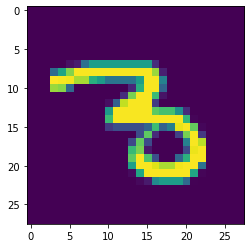

In [13]:
plt.imshow(np.squeeze(x_train[30, ...]))
plt.show()

### Train

In [14]:
digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

In [15]:
%%time
from sys import stdout
from collections import namedtuple
from tensorflow_gan.examples.mnist import util


loss = []   # for loss graph
fig = plt.figure()
n_compare = 10
#epochs_num_del_3 = epochs_num // 3
epochs_to_change_lambda_coeff = 20

epoch = 0
num_of_good_epochs = 0

frechet_distance_edges = [30, 20, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.001]
frechet_distance_checkpoints = []
FDCheckpoint = namedtuple("FDCheckpoint", ["dist"])
for edge in frechet_distance_edges:
    frechet_distance_checkpoints.append(FDCheckpoint(dist=edge))
    
x_fid_test = tf.convert_to_tensor(x_fid_test, dtype=tf.float32)

while True:
#for epoch in range(epochs_num):
    ind = np.random.permutation(x_train.shape[0])
    
    #if epoch > epochs_num_del_3:
    if epoch > epochs_to_change_lambda_coeff:
        K.set_value(lambda_coeff, 1.1 * K.eval(lambda_coeff))
        
    n_batches = int(x_train.shape[0] / batchsize)
    min_loss_per_epoch = 100000
    for i in range(n_batches):
        next_batch = x_train[ind[i * batchsize: (i + 1) * batchsize], ...]
        
        theta_ = generateTheta(L, latent_dim)
        q_z_sample_ = generateQZ(batchsize, latent_dim)
        K.set_value(theta_var, theta_)
        K.set_value(q_z_sample_var, q_z_sample_)
        
        cur_loss = swae_autoencoder.train_on_batch(x=next_batch, y=None)
        if cur_loss < min_loss_per_epoch:
            min_loss_per_epoch = cur_loss
            
        loss.append(cur_loss)
        
        stdout.write("\rEpoch: [%d], Batch: [%d/%d], Loss: %.4f" % (epoch, i, n_batches, cur_loss))
        if i < n_batches - 1:
            stdout.flush()
#         else:
#             stdout.write(", Minimum loss per epoch: %.4f\n" % min_loss_per_epoch)
            
#     if (epoch + 1) % 10 == 0:
#         check_imgs = x_train[:n_compare]
#         decoded_imgs = swae_autoencoder.predict(check_imgs)
#         plot_digits(check_imgs, decoded_imgs)
    if epoch % 5 == 0:
        generated_images = swae_decoder.predict(np.random.normal(size=(len(x_fid_test), 100)))
        generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)

        frechet_distance = util.mnist_frechet_distance(x_fid_test, generated_images)
        stdout.write("\nFID: %.4f" % frechet_distance)

        save_predicted_images(swae_decoder, OUTPUT_DIR, epoch, frechet_distance)

        for i in range(len(frechet_distance_checkpoints)):
            if frechet_distance <= frechet_distance_checkpoints[i].dist and frechet_distance >= frechet_distance_checkpoints[i + 1].dist:
                stdout.write("\n\nSAVING THE GENERATOR MODEL, FD: %.4f\n\n" % frechet_distance)
                save_generator_model(swae_decoder, CHECKPOINT_DIR, epoch, frechet_distance)                    

        if frechet_distance <= 0.01:
            num_of_good_epochs += 1
            if num_of_good_epochs >= 4:
                break
        else:
            num_of_good_epochs = 0
    stdout.write("\n")
    epoch += 1


Epoch: [0], Batch: [198/199], Loss: 0.4425
FID: 22.7726

SAVING THE GENERATOR MODEL, FD: 22.7726


Epoch: [1], Batch: [198/199], Loss: 0.3575
Epoch: [2], Batch: [198/199], Loss: 0.2966
Epoch: [3], Batch: [198/199], Loss: 0.3563
Epoch: [4], Batch: [198/199], Loss: 0.2904
Epoch: [5], Batch: [198/199], Loss: 0.2606
FID: 15.4517

SAVING THE GENERATOR MODEL, FD: 15.4517


Epoch: [6], Batch: [198/199], Loss: 0.2856
Epoch: [7], Batch: [198/199], Loss: 0.3092
Epoch: [8], Batch: [198/199], Loss: 0.2465
Epoch: [9], Batch: [198/199], Loss: 0.2247
Epoch: [10], Batch: [198/199], Loss: 0.2457
FID: 13.3024

SAVING THE GENERATOR MODEL, FD: 13.3024


Epoch: [11], Batch: [198/199], Loss: 0.2140
Epoch: [12], Batch: [198/199], Loss: 0.2155
Epoch: [13], Batch: [198/199], Loss: 0.2244
Epoch: [14], Batch: [198/199], Loss: 0.2244
Epoch: [15], Batch: [198/199], Loss: 0.2049
FID: 16.5999

SAVING THE GENERATOR MODEL, FD: 16.5999


Epoch: [16], Batch: [198/199], Loss: 0.2317
Epoch: [17], Batch: [198/199], Loss: 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

### SAVE MODELS!!!

In [16]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_swae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "ae_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_autoencoder.to_json(), f, indent=4)
swae_autoencoder.save_weights(os.path.join(save_path, "ae_%d_ldim_%d_epochs.h5") % (latent_dim, epochs_num))

with open(os.path.join(save_path, "ae_encoder_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_encoder.to_json(), f, indent=4)
swae_encoder.save_weights(os.path.join(save_path, "ae_encoder_%d_ldim_%d_epochs.h5" % (latent_dim, epochs_num)))

with open(os.path.join(save_path, "ae_decoder_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_decoder.to_json(), f, indent=4)
swae_decoder.save_weights(os.path.join(save_path, "ae_decoder_%d_ldim_%d_epochs.h5" % (latent_dim, epochs_num)))

### Generate random samples from q_z

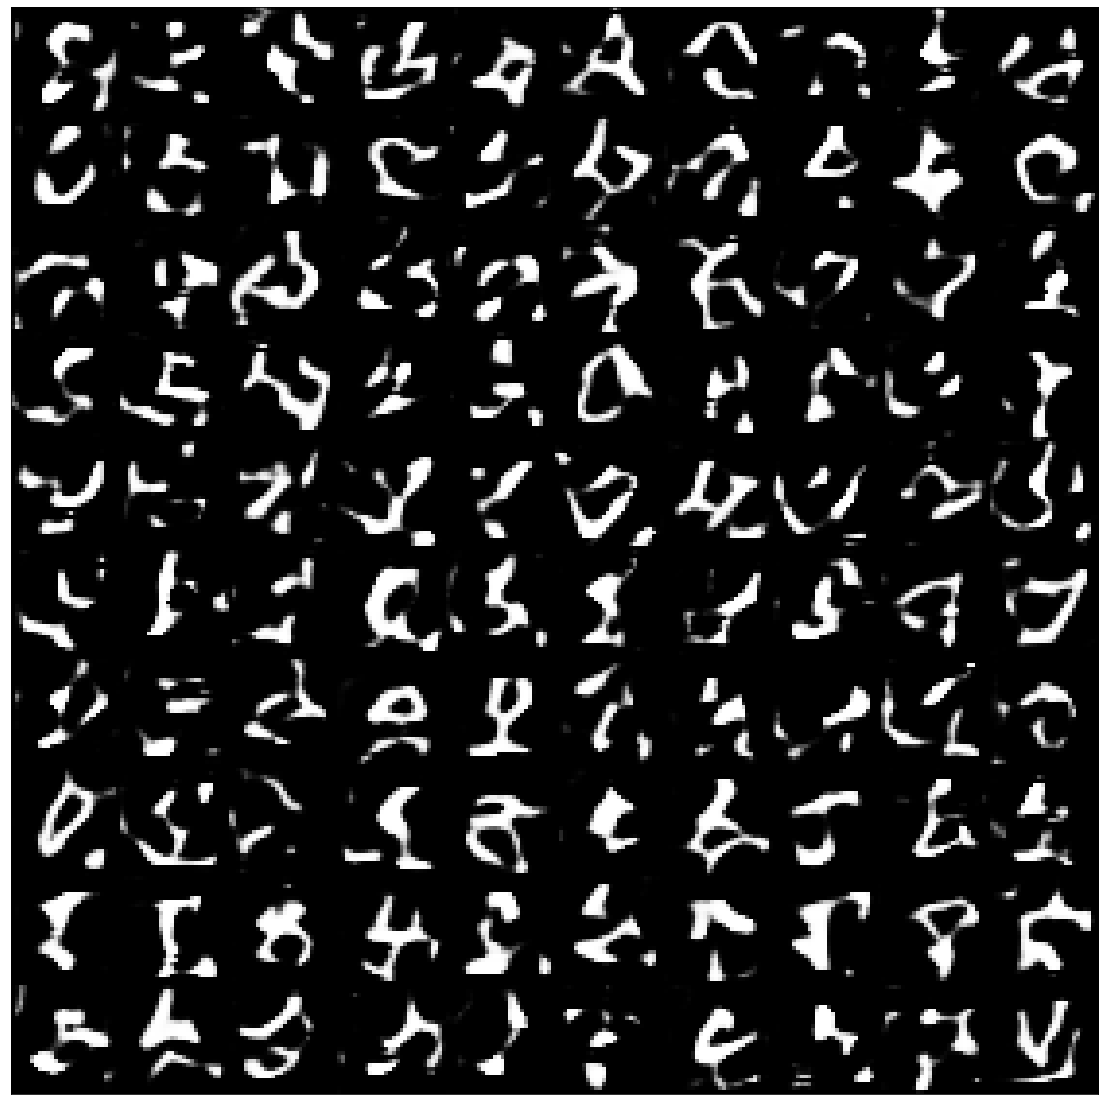

In [15]:
to_compare = []
n_compare = 10
for i in range(10):
    codes = generateQZ(n_compare, latent_dim)
    predicted = swae_decoder.predict(codes)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

In [18]:
n_sample = 10
random_samples = generateQZ(n_sample ** 2, latent_dim)
random_decode_img = np.squeeze(swae_decoder.predict(random_samples))

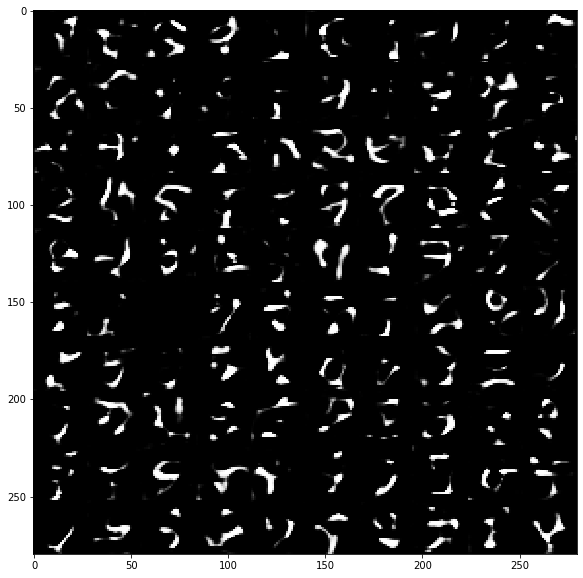

In [19]:
img_random = np.zeros((n_sample * 28, n_sample * 28))
count = 0
for i in range(n_sample):
    for j in range(n_sample):        
        img_random[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = random_decode_img[count, ...]
        count += 1
        
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_random, cmap='gray')
plt.show()

### Loss function graphic

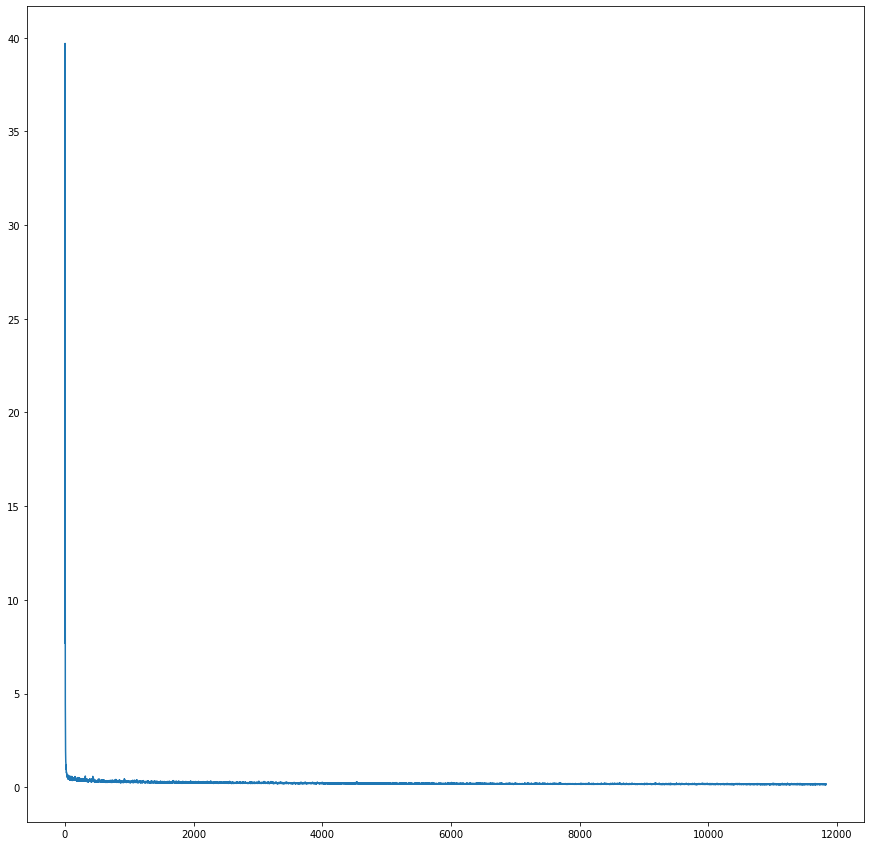

In [20]:
fig = plt.figure(figsize=(15, 15))
plt.plot(np.asarray(loss))